### 1. 频域滤波
#### • 离散傅里叶变换
The discrete Fourier transform (DFT) is the digital version of Fourier transform, which is used to analyze digital signals. The formula of DFT is:
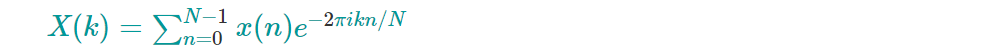
Inverse discrete Fourier transform (IDFT)
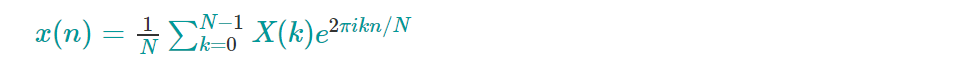
2D discrete Fourier transform
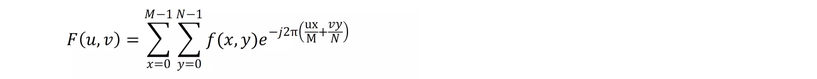

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
%matplotlib inline

def DFT(x):
    N = np.size(x)
    X = np.zeros((N,),dtype=np.complex128)
    for m in range(0,N):    
        for n in range(0,N): 
            X[m] += x[n]*np.exp(-np.pi*2j*m*n/N)
    return X

x = np.linspace(-np.pi, np.pi, 30)
y = np.sin(x)
Y = DFT(y)

from numpy.fft import fft, ifft
Y2 = fft(y)

fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(131)
ax.stem(x,y)
plt.title('y')
ax = fig.add_subplot(132)
ax.stem(x,np.absolute(Y))
plt.title('DFT(y)')
ax = fig.add_subplot(133)
ax.stem(x,np.absolute(Y2))
_ = plt.title('FFT(y)')

#### • 二维离散傅里叶变换

In [ ]:
import cv2
from numpy.fft import fft2, ifft2, fftshift, ifftshift

def visualize(x, gamma=1):
    x = np.absolute(x)
    x - x.min()
    x = x/x.max()
    x = np.power(x, gamma)
    x *= 255
    return x.astype(np.uint8)

im = cv2.imread('./imgs/cameraman.tif')
# im = cv2.imread('./imgs/9.jpg')
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB) / 255

# 直接fft
F_im_1 = fft2(im, axes=(0,1))
# 频谱中心化
F_im = fftshift(fft2(im, axes=(0,1)))
IF_im = ifft2(ifftshift(F_im), axes=(0,1))

fig = plt.figure(figsize=[28,7])
ax = fig.add_subplot(141)
ax.axis('off')
ax.imshow(im)
plt.title('origin img')

ax = fig.add_subplot(142)
ax.axis('off')
ax.imshow(visualize(F_im_1, 0.25))
plt.title('frequency')

ax = fig.add_subplot(143)
ax.axis('off')
ax.imshow(visualize(F_im, 0.25))
plt.title('frequency - swap quadrant')

ax = fig.add_subplot(144)
ax.axis('off')
ax.imshow(visualize(IF_im))
_ = plt.title('reconstruction')


#### • 理想低通滤波器&振铃效应

In [ ]:
def ideal(im, r):
    h, w = im.shape[0], im.shape[1]
    f = np.zeros_like(im)
    for i in range(h):
        for j in range(w):
            f[i,j] = 1 if (i-h/2)**2+(j-w/2)**2 <= r**2 else 0
    return f
            
ideal_filter = ideal(im, 50)
F_im_low = F_im * ideal_filter
IF_im_low = ifft2(ifftshift(F_im_low), axes=(0,1))

fig = plt.figure(figsize=[28,7])
ax = fig.add_subplot(141)
ax.axis('off')
ax.imshow(visualize(F_im, 0.2))
plt.title('frequency')

ax = fig.add_subplot(142, projection='3d')
X = np.arange(ideal_filter.shape[0])
Y = np.arange(ideal_filter.shape[1])
X, Y = np.meshgrid(Y, X)
# ax.imshow(visualize(f))
ax.plot_surface(X, Y, ideal_filter[:,:,0], cmap="gray", linewidth=0, antialiased=False)
plt.title('filter')

ax = fig.add_subplot(143)
ax.axis('off')
ax.imshow(visualize(F_im_low, 0.2))
plt.title('frequency - low')

ax = fig.add_subplot(144)
ax.axis('off')
ax.imshow(visualize(IF_im_low))
plt.title('reconstruction(ringing effect)')


In [ ]:
ideal_filter_spatial = ifftshift(ifft2(ideal_filter, axes=(0,1)))
fig = plt.figure(figsize=[15,7])

ax = fig.add_subplot(121)
ax.axis('off')
ax.imshow(visualize(ideal_filter))
plt.title('ideal filter - frequency domain')

ax = fig.add_subplot(122)
ax.axis('off')
ax.imshow(visualize(ideal_filter_spatial,0.25))
_ = plt.title('ideal filter - spatial domain')

#### • 高斯低通滤波器

In [ ]:
def gaussian(im, gamma):
    h, w = im.shape[0], im.shape[1]
    f = np.zeros_like(im).astype(np.float32)
    for i in range(h):
        for j in range(w):
            f[i,j] = 1/(2*np.pi*gamma**2)*np.exp(((i-h/2)**2+(j-w/2)**2)/(-2*gamma**2))
    f = f/f.max()
    return f
            
gaussian_filter = gaussian(im, 30)
F_im_low = F_im * gaussian_filter
IF_im_low = ifft2(ifftshift(F_im_low), axes=(0,1))

fig = plt.figure(figsize=[28,7])
ax = fig.add_subplot(141)
ax.axis('off')
ax.imshow(visualize(F_im, 0.2))
plt.title('frequency')

ax = fig.add_subplot(142, projection='3d')
X = np.arange(gaussian_filter.shape[0])
Y = np.arange(gaussian_filter.shape[1])
X, Y = np.meshgrid(Y, X)
ax.plot_surface(X, Y, gaussian_filter[:,:,0], cmap="jet", linewidth=1, antialiased=False)
plt.title('filter')

ax = fig.add_subplot(143)
ax.axis('off')
ax.imshow(visualize(F_im_low, 0.2))
plt.title('frequency - low')

ax = fig.add_subplot(144)
ax.axis('off')
ax.imshow(visualize(IF_im_low))
_ = plt.title('reconstruction')

#### • 图像去噪

In [ ]:
h,w,c = im.shape
noise = np.random.randn(h,w,c) * 0.05
im_noise = im + noise

F_im = fftshift(fft2(im_noise, axes=(0,1)))
F_im = F_im * gaussian(im_noise, 40)
IF_im = ifft2(ifftshift(F_im), axes=(0,1))

fig = plt.figure(figsize=[28,7])
ax = fig.add_subplot(131)
ax.axis('off')
ax.imshow(im)
plt.title('origin img')

ax = fig.add_subplot(132)
ax.axis('off')
ax.imshow(visualize(im_noise))
plt.title('noisy img')

ax = fig.add_subplot(133)
ax.axis('off')
ax.imshow(visualize(IF_im))
_ = plt.title('denoise')

### 2.图像旋转
旋转矩阵：
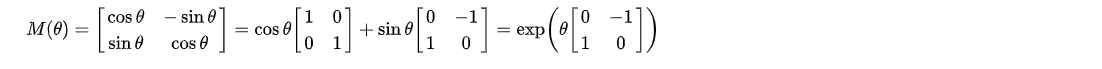

In [ ]:
def rotate(img, angle, expand=False):
    h, w, c = img.shape
    ch, cw  = h/2, w/2
    angle = -angle % 360.0 / 180.0 * np.pi
    matrix = np.matrix([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    
    if expand:
        shape = np.zeros((4,2), dtype=np.int32)
        for index, i, j in [(0,0,0), (1,h,0), (2,0,w), (3,h,w)]:
            coor = np.matrix([[i-ch],[j-cw]])
            rotcoor = np.dot(matrix, coor)
            shape[index,0] = np.round(rotcoor[0] + ch).astype(np.int32)
            shape[index,1] = np.round(rotcoor[1] + cw).astype(np.int32)
        rh, rw = shape.max(0) - shape.min(0)
        crh, crw  = rh/2, rw/2
    else:
        rh, rw = h, w
        crh, crw  = rh/2, rw/2

    rimg = np.zeros((rh, rw, c), dtype=np.uint8)

    for ri in range(rh):
        for rj in range(rw):
            coor = np.matrix([[ri-crh],[rj-crw]])
            rotcoor = np.dot(matrix, coor)

            i = np.round(rotcoor[0] + ch).astype(np.int32)
            j = np.round(rotcoor[1] + cw).astype(np.int32)

            if i >= 0 and j >= 0 and i < img.shape[0] and j < img.shape[1]:
                rimg[ri,rj] = img[i,j]

    return rimg
            
img = cv2.imread('./imgs/9.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

img_r45 = rotate(img, 45)
img_r25 = rotate(img, -25, True)
img_r90 = rotate(img, -90, True)

fig = plt.figure(figsize=[24,6])
ax = fig.add_subplot(141)
ax.axis('off')
ax.imshow(img)
plt.title('origin img')

ax = fig.add_subplot(142)
ax.axis('off')
ax.imshow(visualize(img_r45))
plt.title('rotate 45°')

ax = fig.add_subplot(143)
ax.axis('off')
ax.imshow(visualize(img_r25))
plt.title('rotate -25°')

ax = fig.add_subplot(144)
ax.axis('off')
ax.imshow(visualize(img_r90))
_ = plt.title('rotate -90°')